In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=181bd3db87008ec17b46243c605e3415570648dba919445817a9b5da1bdba9ee
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.8 MB/s eta 0:00:00


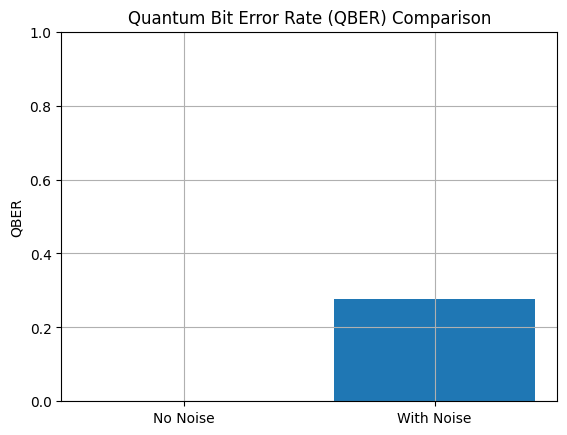

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error # Updated import
import numpy as np
import random
import matplotlib.pyplot as plt # Added import for plotting


# Step 1: Generate random bits and bases
def generate_bits_and_bases(n):
    bits = [random.randint(0, 1) for _ in range(n)]
    bases = [random.choice(['Z', 'X']) for _ in range(n)]
    return bits, bases

# Step 2: Alice encodes qubits
def encode_qubits(bits, bases):
    circuits = []
    for bit, basis in zip(bits, bases):
        qc = QuantumCircuit(1, 1)
        if bit == 1:
            qc.x(0)
        if basis == 'X':
            qc.h(0)
        circuits.append(qc)
    return circuits

# Step 3: Eve intercepts (optional)
def eve_intercepts(circuits, eve_bases):
    new_circuits = []
    backend = AerSimulator() # Use AerSimulator directly
    for qc, basis in zip(circuits, eve_bases):
        qc_copy = qc.copy()
        qc_copy.measure(0, 0)
        tqc = transpile(qc_copy, backend)
        # qobj = assemble(tqc, shots=1) # Remove assemble
        result = backend.run(tqc, shots=1).result() # Use run directly
        measured_bit = int(list(result.get_counts().keys())[0])
        qc_new = QuantumCircuit(1, 1)
        if measured_bit == 1:
            qc_new.x(0)
        if basis == 'X':
            qc_new.h(0)
        new_circuits.append(qc_new)
    return new_circuits

# Step 4: Bob measures
def bob_measures(circuits, bob_bases, noise_model=None): # Added noise_model parameter
    measured_bits = []
    backend = AerSimulator()
    if noise_model:
        backend = AerSimulator(noise_model=noise_model) # Initialize backend with noise
    for qc, basis in zip(circuits, bob_bases):
        if basis == 'X':
            qc.h(0)
        qc.measure(0, 0)
        tqc = transpile(qc, backend)
        result = backend.run(tqc, shots=1).result()
        measured_bit = int(list(result.get_counts().keys())[0])
        measured_bits.append(measured_bit)
    return measured_bits

# Step 5: Sift keys
def sift_keys(alice_bits, alice_bases, bob_bits, bob_bases):
    key_a, key_b = [], []
    for a_bit, a_basis, b_bit, b_basis in zip(alice_bits, alice_bases, bob_bits, bob_bases):
        if a_basis == b_basis:
            key_a.append(a_bit)
            key_b.append(b_bit)
    return key_a, key_b

# Step 6: QBER calculation
def compute_qber(key_a, key_b):
    if not key_a:
        return 0
    mismatches = sum([a != b for a, b in zip(key_a, key_b)])
    return mismatches / len(key_a)




# ####### previous 7
# # Step 7: Run full protocol
# n = 100
# alice_bits, alice_bases = generate_bits_and_bases(n)
# alice_circuits = encode_qubits(alice_bits, alice_bases)

# # Simulate Eve (comment next 2 lines to disable Eve)
# eve_bases = [random.choice(['Z', 'X']) for _ in range(n)]
# intercepted_circuits = eve_intercepts(alice_circuits, eve_bases)

# # Use Alice's original circuits if Eve is inactive:
# # intercepted_circuits = alice_circuits

# bob_bases = [random.choice(['Z', 'X']) for _ in range(n)]
# bob_results = bob_measures(intercepted_circuits, bob_bases)

# key_alice, key_bob = sift_keys(alice_bits, alice_bases, bob_results, bob_bases)
# qber = compute_qber(key_alice, key_bob)

# print(f"Sifted Key Length: {len(key_alice)}")
# print(f"Key Alice: {key_alice}")
# print(f"Key Bob:   {key_bob}")
# print(f"QBER: {qber:.2f}")





############ New 7
n = 100
alice_bits, alice_bases = generate_bits_and_bases(n)
alice_circuits = encode_qubits(alice_bits, alice_bases)
intercepted_circuits = alice_circuits  # No Eve for now
bob_bases = [random.choice(['Z', 'X']) for _ in range(n)]

# Run without noise
bob_results_no_noise = bob_measures(intercepted_circuits, bob_bases)
key_a_no_noise, key_b_no_noise = sift_keys(alice_bits, alice_bases, bob_results_no_noise, bob_bases)
qber_no_noise = compute_qber(key_a_no_noise, key_b_no_noise)

# Add depolarizing noise model
noise_model = NoiseModel()
error = depolarizing_error(0.1, 1)  # 10% noise
noise_model.add_all_qubit_quantum_error(error, ['x', 'h'])

# Run with noise
bob_results_with_noise = bob_measures(intercepted_circuits, bob_bases, noise_model=noise_model)
key_a_noise, key_b_noise = sift_keys(alice_bits, alice_bases, bob_results_with_noise, bob_bases)
qber_with_noise = compute_qber(key_a_noise, key_b_noise)

# Visualize QBER
labels = ['No Noise', 'With Noise']
qbers = [qber_no_noise, qber_with_noise]

plt.bar(labels, qbers)
plt.title("Quantum Bit Error Rate (QBER) Comparison")
plt.ylabel("QBER")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [ ]:
print(f"QBER without noise: {qber_no_noise:.2f}")
print(f"QBER with noise:    {qber_with_noise:.2f}")